<a href="https://colab.research.google.com/github/LichenXia198/Deeping-Learning-project/blob/main/Reproducibility_project_Group_116.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Reproducibility project
This blog represents an explanation and its corresponding implementation of the Weighted Joint Distribution Optimal Transport （WJDOT） in the paper "Multi-source Domain Adaptation via Weighted Joint
Distributions Optimal Transport" from Rosanna Turrisi, Rémi Flamary, Alain Rakotomamonjy and Massimiliano Pontil. This paper assumes that the dataset on which we would like to apply our model does not have ground truth labels and several training datasets from shifted distributions are used to train the model, which is usually the case in reality. 
Our project mainly focuses to reproduce the second numeric experiment(Object recognition) in the paper. The source code is not available, thus we tried to follow all the steps and hyperparameter settings in the paper. For hyperparameters that are provided in the paper, we looked for other related papers and designed an informal tuning method.\
The full source code is available at https://github.com/LichenXia198/Deeping-Learning-project/blob/main/Reproducibility_project_source_code_Group_116.ipynb

**Group 116**\
Work distribution:\
**Lichen Xia 5395704**: Implementation of JDOT and WJDOT. Writing blog\
**Ye Yuan 5218683**: Hyperparameter tuning. Experiment. Writing blog

##Introduction
In many deep learning and machine learning algorithms, it is assumed that training datasets (*source*) and test datasets (*target*) are *i.i.d* drawn from the same distribution. However, this is not always the case in practice. For example, a spam filter that trained on a certain group of email users during training must adapt to a new target user when deployed. Therefore, models should be able to learn from the data from *source* distributions and gain good performance on the data from *target* distributions since the *target* does not have labels (Domain Adaption). Sometimes distinct datasets from different *source* distributions are available and we should leverage all *sources*, and the *sources* which are more similar to the *target* should have more impacts. This paper introduces Weighted Joint Distribution Optimal Transport (WJDOT) which bases on the already successful Joint Distribution Optimal Transport (JDOT) by looking for a convex combination of the joint distribution of *sources* with minimal distance to the *target* one.
Next, this blog will introduce essential components of WJDOT as well as their implementations.

##Components
In this section, Optimal Transport and Joint Distribution Optimal Transport will be introduced, and some implementation details will be presented.

###Optimal Transport(OT)
The Optimal Transport is introduced in [1] to solve the domain adpation problem. It can be difined as:
$$\mathbf{W_c(\mu_1,\mu_2)} = \min_\gamma \sum_{ij} C_{ij}\mathbf{\gamma_{ij}}$$
where $\mu_1\  and\ \mu_2$ are discrete probability measures of two different distributions. $C_{ij}$ represents the cost of transport from $\mu_1\  to\ \mu_2$ and $\gamma$ is the **optimal transport plan** which minimizes the over cost of transport. By Optimal Transport, we manage to find an efficient way to transport between *source* domain and *target* domain. \
With the code provided by [2], we can easily compute the optimal transport matrix in our implementation.

###Joint Distribution Optimal Transport(JDOT)
This method is proposed in [3] based on OT to address unsupervised domain adapations where the lables of *target* is not available anymore. In JDOT, the equation of OT is translated into:
$$\min_f\{\mathbf{W_D(p_1,p^f)} = \min_\gamma \sum_{ij}D(g(x^i_1),y^i_1;g(x^j_2),f(g(x^j_2)))\mathbf{\gamma_{ij}}\}$$
where $p_1$ and $p^f$ are the empirical distributions of *source* domain and *target* domain repectively.$x$ and $y$ are samples and labels drawn from corresponding distributions.$g()$ is the embedding function which can also be estimated in the deep learning framework. But we keep it fixed in the experiment. $f$ is a predictive function/classifier which predicts the labels of *target* samples. It is also the final product of JDOT. In short, JDOT tried to train a model which has a good performance on the *target* dataset by using samples (with their labels) drawn from the *source* domain. $W_D$ stands for Wasserste Distance.\
Further, $$D(g(x_1),y_1;g(x_2),f(g(x_2))) = \beta(g(x_1)-g(x_2))^2+L(y_1,f(g(x_2)))$$
$D$ is the ground cost metric used in JDOT. It measures not only the embedding discrepancy but also the difference between labels. $\beta$ is one hyperparameter that needs to be fine-tuned. L is a loss function that needs to be defined. And we use the sum of the squared errors (SSE) as the loss function in our implementation.



In [ ]:
# Calculate Wasserste Distance, C0 is embedding discrepancy, y is label of source, target_predict is predict label of target
def my_loss_custom(beta,G,C0,target_predict,y):
  loss = torch.sum(torch.square(torch.cdist(y,target_predict))*G)
  C = beta*C0 + torch.square(torch.cdist(y,target_predict))
  lose = C*G
  return torch.sum(lose)

Although the source code of JDOT is provided by [3], the code is not implemented in Pytorch and thus cannot be used to compare with our WJDOT. Therefore, we reimplement the basic functions of JDOT in Pytorch. It is a simplified version. However, we did get lots of inspiration from the source code while implementing JDOT and WJDOT.\
Our JDOT implementation:

In [ ]:
# train and test JDOT with test set/validation set
def train_jodt(le,wd,all_features,target,target_t,all_labels,target_labels,target_labels_t,writer):
  n1 = list(all_features.size())[0]
  ntest =list(target.size())[0]
  wa1=np.ones((n1,))/n1
  wb=np.ones((ntest,))/ntest 
  y1 = all_labels
  orign = target_labels
  orign_test = target_labels_t
  target = target.float()
  target_test=target_t
  target_test = target_test.float()
  all_features = all_features.float()
  all_labels = all_labels.float()

  C1=torch.square(torch.cdist(all_features,target))
  beta1 = 1/torch.max(C1).data.item()
  C1=C1/torch.max(C1)

  f = MyNet()

  optimizer = optim.Adam(f.parameters(),lr=le,betas=(0.9,0.99),weight_decay=wd ,eps=math.exp(-8))
  
  ave_train_loss = 0
  ave_test_loss = 0
  ave_train_acc = 0
  ave_test_acc = 0
  convergence = 0
  previous_loss = torch.zeros(1)
  k = 0

  while True:
  
    tp = f(target)
    
    # Calculte Optimal Transport matrix
    C_1 = beta1*C1+ torch.square((torch.cdist(y1,tp)))
    G1_solution=ot.emd(wa1,wb,C_1.detach().numpy())
    G1=torch.from_numpy(G1_solution)
  
    optimizer.zero_grad()
    # Calculate Wasserste Distance
    lose1 = my_loss_custom(beta1,G1,C1,tp,y1)
    lose = lose1
    lose.backward()
    optimizer.step()

    #calculate test lose test accurcy, train lose and train accurcy
    trainloss = torch.mean((tp - orign) ** 2)
    traincorrect = torch.sum(torch.argmax(tp, axis=1) == torch.argmax(orign, axis=1))/len(tp)

    test_predict = f(target_test)
    testloss = torch.mean((test_predict - orign_test) ** 2)
    testcorrect = torch.sum(torch.argmax(test_predict, axis=1) == torch.argmax(orign_test, axis=1))/len(test_predict)

    ave_train_loss += trainloss
    ave_train_acc += traincorrect.item()

    ave_test_loss += testloss
    ave_test_acc += testcorrect.item()
  
    # print test lose test accurcy, train lose and train accurcy in tensorboard
    if k%10 ==0 :
      train_loss = ave_train_loss/10
      test_loss = ave_test_loss/10
      writer.add_scalars('Loss', {'Train': train_loss, 'Test':test_loss}, k)
      ave_train_loss = 0
      ave_test_loss = 0
      train_acc = ave_train_acc/10
      test_acc = ave_test_acc/10
      writer.add_scalars('Accuracy',{'Train': train_acc,'Test':test_acc} , k)
      ave_train_acc = 0
      ave_test_acc = 0
    
    # Check if convergent
    if k%10 ==0:
      if previous_loss.data.item() -  lose.data.item() <= 0.0001:
        convergence+=1
      else:
        convergence = 0
      previous_loss = lose.detach().clone()
    if convergence>5:
      break
    k+=1



  # Calculate final test accurcy and print
  test_predict = f(target_test)
  correct = torch.argmax(test_predict, axis=1) == torch.argmax(orign_test, axis=1)
  print("jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj")
  print("convergent!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
  print(torch.sum(correct)/len(test_predict))
  print("jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj")

## Weighnted Joint Distribution Optimal Transport(WJDOT)
### Defination
WJODT aims to solve unsupervised domain adaptation when multiple datasets from different *sources* are available. It introduces a vector $\alpha$ which assigns weight to different *sources*. This problem can be expressed as $$\min_{f,\alpha}\mathbf{W_D(\sum_s\alpha_sp_s,p^f)}$$
where $S$ is a set of available *sources*, and $\sum_s\alpha_sp_s$ is a weighted convex combination of *source* distributions.

### Implementation 
In our implementation, we interpret above formula as
$$\min_{f,\alpha}\sum_s\alpha_s\mathbf{W_D(p_s,p^f)}$$
Thus the overall Wasserste Distance is the weighted average of Wasserste Distances of different *sources*\
Before calculating Wasserste Distance, we first compute the optimal transport matrix based on data features, labels of *source* and newly predicted labels of *target*.
We optimized this overall Wasserste Distance by alternative gradient descent provided in the paper (algorithm 1). $\alpha$ is normalized after every optimization step.


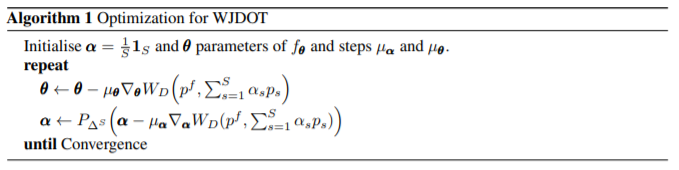

Our implemnetation of WJODT:

In [ ]:
# Nomalize alphas
def normalize_alphas_inplace(alphas):
  alpha1, alpha2, alpha3 = alphas
  alpha1 = torch.clamp_(alpha1, min=0)
  alpha2 = torch.clamp_(alpha2, min=0)
  alpha3 = torch.clamp_(alpha3, min=0)
  sum = alpha1+alpha2+alpha3
  alpha1 = alpha1.div_(sum)
  alpha2 = alpha2.div_(sum)
  alpha3 = alpha3.div_(sum)
  return alpha1, alpha2, alpha3

# train and test WJDOT with test set/validation set
def train(lerate,wd,lra,source1,source2,source3,target,source1_labels,source2_labels,source3_labels,target_labels,target_labels_t,target_t,writer):
  
  #Prepare datasets
  source1 = source1.float()
  source2 = source2.float()
  source3 = source3.float()
  target = target.float()
  n1 = list(source1.size())[0]
  n2 = list(source2.size())[0]
  n3 = list(source3.size())[0]
  ntest =list(target.size())[0]
  wa1=np.ones((n1,))/n1
  wa2=np.ones((n2,))/n2
  wa3=np.ones((n3,))/n3
  wb=np.ones((ntest,))/ntest 
  y1 = source1_labels
  y2 = source2_labels
  y3 = source3_labels
  orign = target_labels
  orign_test = target_labels_t

  target_test=target_t
  target_test = target_test.float()

  # Initialize alphas
  alpha1 = torch.ones(1)/3
  alpha2 = torch.ones(1)/3
  alpha3 = torch.ones(1)/3
  alpha1.requires_grad = True
  alpha2.requires_grad = True
  alpha3.requires_grad = True

  # Initialize embedding discrepancies and beta
  C1=torch.square(torch.cdist(source1,target))
  beta1 = 1/torch.max(C1).data.item()
  C1=C1/torch.max(C1)

  C2=torch.square(torch.cdist(source2,target))
  beta2 = 1/torch.max(C2).data.item()
  C2=C2/torch.max(C2)

  C3=torch.square(torch.cdist(source3,target))
  beta3 = 1/torch.max(C3).data.item()
  C3=C3/torch.max(C3)
  beta_b = (beta1+beta2+beta3)/3


  # Initialize model
  f = MyNet()

  optimizer = optim.Adam(f.parameters(),lr=lerate,betas=(0.9,0.99),weight_decay = wd,eps=math.exp(-8))
  optimizerA = optim.Adam([alpha1, alpha2, alpha3],lr=lra,betas=(0.9,0.99),eps=math.exp(-8))

  convergence = 0
  ave_train_loss = 0
  ave_test_loss = 0
  ave_train_acc = 0
  ave_test_acc = 0
  previous_loss = torch.zeros(1)
  k = 0

  # Start training
  while True:
  
    tp = f(target)
  
    # Normalize alphas
    with torch.no_grad():
      alpha1, alpha2, alpha3 = normalize_alphas_inplace((alpha1, alpha2, alpha3))
    
    # Overall Beta
    beta_b = alpha1*beta1 + alpha2*beta2 + alpha3*beta3

    # Optimal transport matrix for each source domain with target domain
    C_1 = beta_b*C1+ torch.square((torch.cdist(y1,tp)))
    G1_solution=ot.emd(wa1,wb,C_1.detach().numpy())
    G1=torch.from_numpy(G1_solution)


    C_2 = beta_b*C2+ torch.square((torch.cdist(y2,tp)))  
    G2_solution=ot.emd(wa2,wb,C_2.detach().numpy())
    G2=torch.from_numpy(G2_solution)
  

    C_3 = beta_b*C3+ torch.square((torch.cdist(y3,tp)))  
    G3_solution=ot.emd(wa3,wb,C_3.detach().numpy())
    G3=torch.from_numpy(G3_solution)

    optimizer.zero_grad()
    optimizerA.zero_grad()

    # Wasserste Distance for each source domain
    lose1 = my_loss_custom(beta_b,G1,C1,tp,y1)
    lose2 = my_loss_custom(beta_b,G2,C2,tp,y2)
    lose3 = my_loss_custom(beta_b,G3,C3,tp,y3)

    # Overall Wasserste Distance
    lose = (alpha1*lose1 + alpha2*lose2+ alpha3*lose3)

    lose.backward()
    optimizer.step()
    optimizerA.step()
    if k%10 == 0:
      # every 10 iterations check if convergent
      if previous_loss.data.item() -  lose.data.item() <= 0.001:
        convergence+=1
      else:
        convergence = 0
      previous_loss = lose.detach().clone()


    #calculate test lose test accurcy, train lose and train accurcy    
    trainloss = torch.mean((tp - orign) ** 2)
    traincorrect = torch.sum(torch.argmax(tp, axis=1) == torch.argmax(orign, axis=1))/len(tp)

    test_predict = f(target_test)
    testloss = torch.mean((test_predict - orign_test) ** 2)
    testcorrect = torch.sum(torch.argmax(test_predict, axis=1) == torch.argmax(orign_test, axis=1))/len(test_predict)

    ave_train_loss += trainloss
    ave_train_acc += traincorrect.item()

    ave_test_loss += testloss
    ave_test_acc += testcorrect.item()
  
    # print test lose test accurcy, train lose and train accurcy in tensorboard
    if k%10 ==0 :
      train_loss = ave_train_loss/10
      test_loss = ave_test_loss/10
      writer.add_scalars('WLoss', {'Train': train_loss, 'Test':test_loss}, k)
      writer.add_scalars('WassersteinLoss', {'Train': lose}, k)
      ave_train_loss = 0
      ave_test_loss = 0
      train_acc = ave_train_acc/10
      test_acc = ave_test_acc/10
      writer.add_scalars('WAccuracy',{'Train': train_acc,'Test':test_acc} , k)
      ave_train_acc = 0
      ave_test_acc = 0

    if convergence>5:
      break
    k+=1


  # Calculate final test accurcy and print
  test_predict = f(target_test)
  testloss = torch.mean((test_predict - orign_test) ** 2)
  correct = torch.argmax(test_predict, axis=1) == torch.argmax(orign_test, axis=1)
  print("############################")
  print("convergent!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
  print(torch.sum(correct)/len(test_predict))
  print("############################")

## Experiment
Our task is to reproduce part of the second experiment (Object recognition) in the paper. In this experiment, the Caltech-Office dataset [4,5,6,1] which contains pictures from four different domains (Amazon, Dslr, Caltech and Webcam). A simple classifier is trained through JDOT and WJODT respectively and the final performance(test accuracy) is compared. While training, three of four domains are used as *source* domains, and the rest domain is used as the *target* domain. So there are in total four comparison results. When a domain is the *target* domain, its label is only available during evaluation(test set). We tried to follow all the settings and steps in the paper, but many of them lack details.

### Classifer
In the experiment, a network with one fully connected layer is used as the classifier. However, in the paper, there is no description of this network. We then decided to use a linear layer with RELU as its activation function.\
Our network is as follows

In [ ]:
class MyNet(nn.Module):
    
    
    def __init__(self):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(4096, 10)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        return h

### Datasets
The paper uses for the
embedding function g the output of the 7th layer of a pre-trained DeCAF mode[7], However, the pre-trained DeCAF is not available now. Luckily, on https://github.com/jindongwang/transferlearning/blob/master/data/dataset.md we find the output of the 6th layer of the pre-trained DeCAF, which has the same embedding space.
Before training, the datasets are normalized, and the order of samples is ramdomized and each of them are spilt into training set(70%), validation set(20%) and testing set(10%) as the paper:


In [ ]:
#process amazon datset
amazon = loadmat('amazon_decaf.mat')
#Normalization
norm = np.linalg.norm(amazon["feas"])
amazon_feas = torch.from_numpy(amazon["feas"]/norm)
amazon_labels = torch.zeros(len(amazon["labels"]),10)
#convert label to one-hot key
for i in range(len(amazon["labels"])):
  amazon_labels[i][amazon["labels"][i][0]-1] = 1
#Ramdomize the order of samples
idx = torch.randperm(amazon_feas.shape[0])
amazon_feas = amazon_feas[idx].view(amazon_feas.size())
amazon_labels = amazon_labels[idx].view(amazon_labels.size())
#split dataset
train = math.ceil(amazon_feas.shape[0]*0.7)
vaild = math.floor(amazon_feas.shape[0]*0.2)
test = amazon_feas.shape[0]-train-vaild
amazon_feas, amazon_feas_v, amazon_feas_t = torch.split(amazon_feas, [train,vaild,test])
amazon_labels, amazon_labels_v, amazon_labels_t = torch.split(amazon_labels, [train,vaild,test])
#################

#process caltech datset
caltech = loadmat('caltech_decaf.mat')
#Normalization
norm = np.linalg.norm(caltech["feas"])
caltech_feas = torch.from_numpy(caltech["feas"]/norm)
caltech_labels = torch.zeros(len(caltech["labels"]),10)
#convert label to one-hot key
for i in range(len(caltech["labels"])):
  caltech_labels[i][caltech["labels"][i][0]-1] = 1
#Ramdomize the order of samples
idx = torch.randperm(caltech_feas.shape[0])
caltech_feas = caltech_feas[idx].view(caltech_feas.size())
caltech_labels = caltech_labels[idx].view(caltech_labels.size())
#split dataset
train = math.ceil(caltech_feas.shape[0]*0.7)
vaild = math.floor(caltech_feas.shape[0]*0.2)
test = caltech_feas.shape[0]-train-vaild
caltech_feas, caltech_feas_v, caltech_feas_t = torch.split(caltech_feas, [train,vaild,test])
caltech_labels, caltech_labels_v, caltech_labels_t = torch.split(caltech_labels, [train,vaild,test])

###############

#process dslr datset
dslr = loadmat('dslr_decaf.mat')
#Normalization
norm = np.linalg.norm(dslr["feas"])
dslr_feas = torch.from_numpy(dslr["feas"]/norm)
dslr_labels = torch.zeros(len(dslr["labels"]),10)
#convert label to one-hot key
for i in range(len(dslr["labels"])):
  dslr_labels[i][dslr["labels"][i][0]-1] = 1
#Ramdomize the order of samples
idx = torch.randperm(dslr_feas.shape[0])
dslr_feas = dslr_feas[idx].view(dslr_feas.size())
dslr_labels = dslr_labels[idx].view(dslr_labels.size())
#split dataset
train = math.ceil(dslr_feas.shape[0]*0.7)
vaild = math.floor(dslr_feas.shape[0]*0.2)
test = dslr_feas.shape[0]-train-vaild
dslr_feas, dslr_feas_v, dslr_feas_t = torch.split(dslr_feas, [train,vaild,test])
dslr_labels, dslr_labels_v, dslr_labels_t = torch.split(dslr_labels, [train,vaild,test])

###############

#process webcam datset
webcam = loadmat('webcam_decaf.mat')
#Normalization
norm = np.linalg.norm(webcam["feas"])
webcam_feas = torch.from_numpy(webcam["feas"]/norm)
webcam_labels = torch.zeros(len(webcam["labels"]),10)
#convert label to one-hot key
for i in range(len(webcam["labels"])):
  webcam_labels[i][webcam["labels"][i][0]-1] = 1
#Ramdomize the order of samples
idx = torch.randperm(webcam_feas.shape[0])
webcam_feas = webcam_feas[idx].view(webcam_feas.size())
webcam_labels = webcam_labels[idx].view(webcam_labels.size())
#split dataset
train = math.ceil(webcam_feas.shape[0]*0.7)
vaild = math.floor(webcam_feas.shape[0]*0.2)
test = webcam_feas.shape[0]-train-vaild
webcam_feas, webcam_feas_v, webcam_feas_t = torch.split(webcam_feas, [train,vaild,test])
webcam_labels, webcam_labels_v, webcam_labels_t = torch.split(webcam_labels, [train,vaild,test])

Before training the JDOT, training datasets of three *sources* are combined into one big traning set. For example:


In [ ]:
#The datasets of webcam, amazon and dslr are combined into one single dataset
all_features = torch.cat((webcam_feas,amazon_feas,dslr_feas))
all_labels = torch.cat((webcam_labels,amazon_labels,dslr_labels))

###Optimizer
Adam optimizers are used to optimize the network and the $\alpha$. It is also worth noticing that the experiment in the paper does not use mini-batches sub-sampled from the *source* and *target* datasets. Therefore, we use the whole training set in each iteration of the training process.

###Hyperparameters
Hyperparameters need to be set:


*   Learning rate of Classifer
*   Learning rate of $\alpha$
*   $\beta$, different *souces* share one $\beta$ during a complete traning process
*   L2 regularization parameter
*   momentum and $\epsilon$ of the adam optimizer
*   Tolerance for convergent

In above hyperparameters, only the values of momentum and $\epsilon$ are explicitly provided. \
For $\beta$, we referred to the suggestion in [3]. The setting is as follows:


In [ ]:
#embeding discrepancy between source 1 and target
C1=torch.square(torch.cdist(source1,target))
beta1 = 1/torch.max(C1).data.item()
#embeding discrepancy between source 2 and target
C2=torch.square(torch.cdist(source2,target))
beta2 = 1/torch.max(C2).data.item()
#embeding discrepancy between source 3 and target
C3=torch.square(torch.cdist(source3,target))
beta3 = 1/torch.max(C3).data.item()
#final β
beta = (beta1*alpha1+beta2*alpha2+beta3*alpha3)

Alpha in the code is the weight of each *source* ($\alpha$).

The paper uses the sum of the squared errors (SSE) between the estimated outputs f(X) and
their estimated cluster centroids on the *target* data to overcome the lack of *target* labels and validate other hyperparameters. We didn't manage to implement this because there is no further information in the paper anymore. After discussed with our supervisor, we decided to do a trick. When Webcam is used as *target*, we used its labels to tune the hyperparameters (we cannot do this in reality due to lack of *target* labels). The fine-tuned hyperparameters keep unchanged when other datasets are used as *target*. Table below presents the hyperparameters used throughout the whole experiment.
\begin{array}{lllll}
         & learning\ rate     & weight\ decay     & momentum & \epsilon &tolerance     & learning\ rate\ \alpha  \\
JDOT & 0.06 & 0.0002 & 0.9& e^{-8} & 0.0001 & - \\
WJDOT    & 0.06 & 0.0002 &0.9&e^{-8} & 0.001   & 0.001\\                  
\end{array}
For hyperparameters unmentioned, we use default values in Pytorch.

## Results
The table below demonstrates the results from the paper we are asked to reproduce . Baseline stands for the performance of JDOT. Each column is the performance comparison between JODT and WJDOT when one of four datasets is used as the *target*. For example, for the first column, Webcam is the *target*. From this table, we can find WJODT on average have a better performance than JDOT.

\begin{array}{lllll}
         & Webcam     & Amazon     & Dslr       & Caltech10  \\
Baseline & 89.33\pm1.63 & 93.13\pm0.07 & 94.12\pm0.00 & 82.65\pm1.84 \\
WJDOT    & 89.33\pm2.91 & 94.23\pm0.90 & 100\pm0.00   & 85.93\pm2.07\\                  
\end{array}

The table below presents the results of our implementation. For each situation, we did experiment with five different training set and test set pairs .Since we used the first column to tune hyperparameters, there is a huge improvement for WJDOT in the first column.
\begin{array}{lllll}
         & Webcam     & Amazon     & Dslr       & Caltech10  \\
Baseline & 87.95 & 88.50 & 88.51 & 96.55 \\
WJDOT    & 92.16 & 82.98 & 93.75   & 84.82\\                  
\end{array}
Our results are different from the results in the paper. Although WJDOT has better performance while Webcam or Dslr is used as the *target*, there is a huge gap between JDOT and WJDOT when Amazon and Caltech are the *target*.

###Discussion
We come up with some factors that make the result so different


1.   In the paper, the output of the 7th convolution layer of Decaf is used as embedding, but we uses the output of 6th convolution layer.
2.   We did not directly tune the hyperparameters while Amazon, Dslr or Caltech is the *target*. Instead, we use the hyperparameters we found when Webcam is the *target*. This explains why WJDOT also performs well in the third column since Dslr is similar to the Webcam (their wassetren distance is low). If we can fine-tune the hyperparameters for each situation, the performance of WJDOT should improve.
3. This result also suggests that WJDOT is more sensitive to the hyperparameters compared JDOT (JDOT's performance is stable in all situations)



##One interesting finding
In the paper, $\alpha$ becomes a one-hot vector at the end of each adaption problem. The table below is "table 3" from the appendix of the paper (section B.2). 
\begin{array}{lllll}
\alpha      & Webcam     & Amazon     & Dslr       & Caltech10  \\
Webcam & - & 0 & 1 & 0 \\
Amazon    & 0 & - & 0   & 1\\  
Dslr    & 1 & 0 & -   & 0\\ 
Caltech10    & 0 & 1 & 0   & -\\                  
\end{array}
It shows that in the end, only one *source* dataset has an impact (it acquires the whole weight). However, we find that sometimes this is caused by overfitting. Below two graphs contain the test accuracy and test loss during one training process while the Webcam is used as the *target*. It is obvious that the accuracy begins dropping and the loss starts to grow at a certain point.
 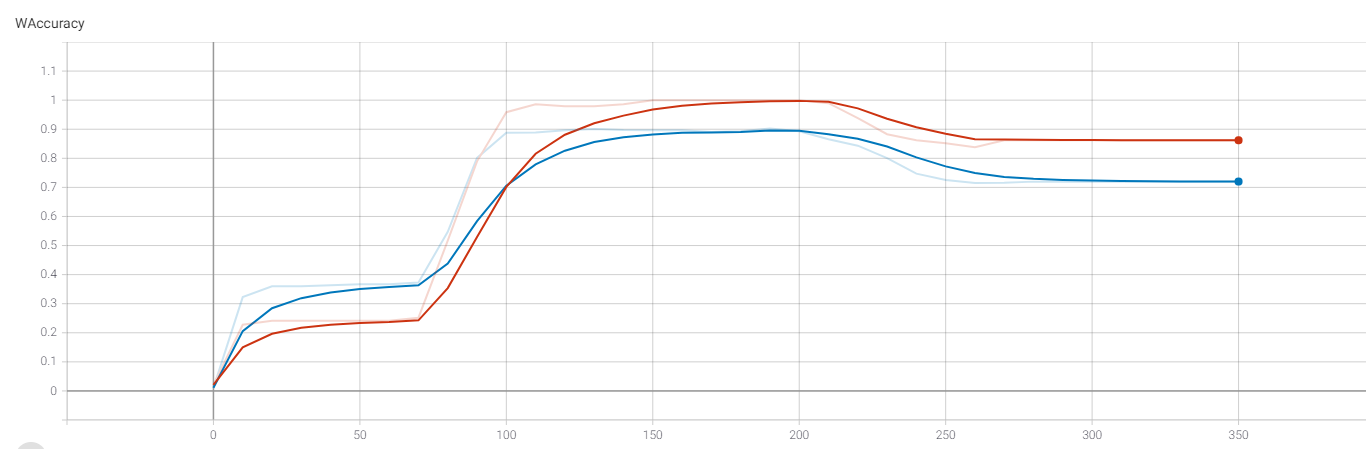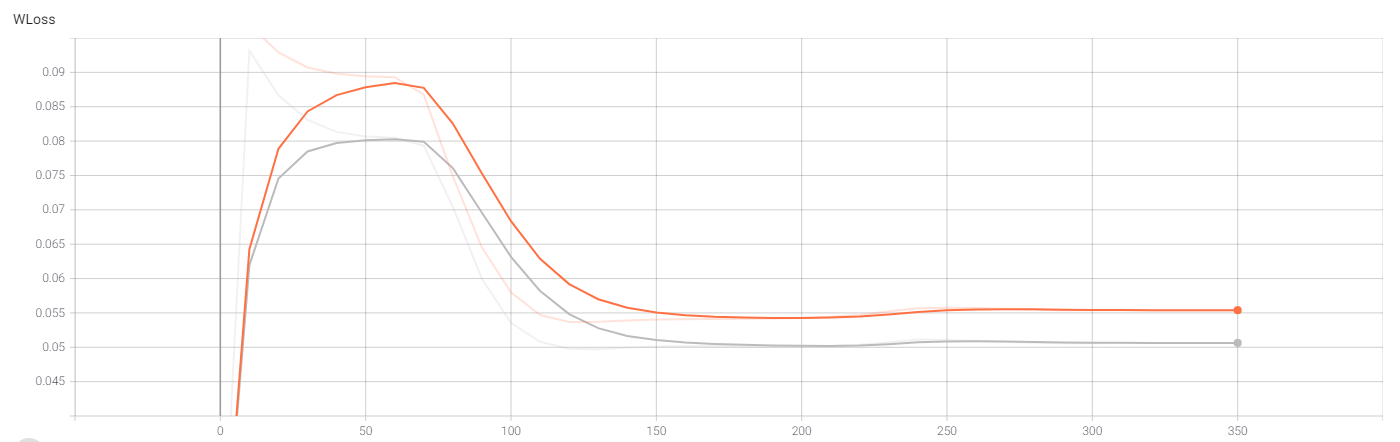
If we try to stop the training at that point, the $\alpha$ will not be a one-hot vector any more, instead, each *source* domain get a different weight as the below table presents
\begin{array}{lllll}
\alpha      & Webcam     & Amazon     & Dslr       & Caltech10  \\
Webcam & - & 0.2961 & 0.2341 & 0.4698 \\                
\end{array}
This result actually makes sense for us. If in the end only one *source* get non-zero weight, the classifier is training only on that *source* dataset, which makes it more prone to overfit since fewer samples are used during training (the training set shrinks).
This finding suggests that the performance of WJDOT presented in the paper still has the potential to be improved further by tuning hyperparameters.

## Conclusion
In this blog, we introduced the technology we tried to implement and compared our reproduced results with the original results in the paper. Although we did not manage to reproduce all desired results, we concluded some factors that led to this failure and observed an interesting phenomenon that did not be mentioned in the paper. Our results also suggest that the original results are convincing and can be improved further

## Reference
1. Nicolas Courty, Rémi Flamary, Devis Tuia, and Alain Rakotomamonjy, “Optimal transport for domain adaptation,” CoRR, vol. abs/1507.00504, 2015.
2. Rémi Flamary, Nicolas Courty, Alexandre Gramfort, Mokhtar Z. Alaya, Aurélie Boisbunon, Stanislas Chambon, Laetitia Chapel, Adrien Corenflos, Kilian Fatras, Nemo Fournier, Léo Gautheron, Nathalie T.H. Gayraud, Hicham Janati, Alain Rakotomamonjy, Ievgen Redko, Antoine Rolet, Antony Schutz, Vivien Seguy, Danica J. Sutherland, Romain Tavenard, Alexander Tong, Titouan Vayer,
POT Python Optimal Transport library,
Journal of Machine Learning Research, 22(78):1−8, 2021.
Website: https://pythonot.github.io/
3. Nicolas Courty, Rémi Flamary, Amaury Habrard, and Alain Rakotomamonjy, “Joint distribution
optimal transportation for domain adaptation,” in Advances in Neural Information Processing
Systems 30, I. Guyon, U. V. Luxburg, S. Bengio, H. Wallach, R. Fergus, S. Vishwanathan, and
R. Garnett, Eds., pp. 3730–3739. Curran Associates, Inc., 2017.
4. Kate Saenko, Brian Kulis, Mario Fritz, and Trevor Darrell, “Adapting Visual Category Models
to New Domains,” in Computer Vision – ECCV 2010, Kostas Daniilidis, Petros Maragos, and
Nikos Paragios, Eds., Berlin, Heidelberg, 2010, pp. 213–226, Springer Berlin Heidelberg
5.  R Gopalan, Ruonan Li, and Rama Chellapa, “Domain adaptation for object recognition: An
unsupervised approach,” in 2011 IEEE International Conference on Computer Vision (ICCV).
IEEE, 2011, pp. 999–1006, IEEE.
6. Boqing Gong, Yuan Shi, Fei Sha, and Kristen Grauman, “Geodesic flow kernel for unsupervised
domain adaptation.,” in CVPR. 2012, pp. 2066–2073, IEEE Computer Society
7. Jeff Donahue, Yangqing Jia, Oriol Vinyals, Judy Hoffman, Ning Zhang, Eric Tzeng, and Trevor
Darrell, “Decaf: A deep convolutional activation feature for generic visual recognition,” in
International conference on machine learning, 2014, pp. 647–655.